# Model Monitoring - Data Drift Detection

## Objetivo
Detectar cambios en la distribución de datos (Data Drift) que puedan afectar el desempeño del modelo en producción.

## Componentes
- **Tests Estadísticos**: KS test, PSI, Jensen-Shannon divergence, Chi-cuadrado
- **Visualizaciones**: Comparación de distribuciones históricas vs actuales
- **Sistema de Alertas**: Umbrales críticos y recomendaciones de retraining
- **Dashboard Streamlit**: Visualización interactiva de métricas de drift


## 1. Imports y Configuración

In [18]:
# Imports principales
import pandas as pd
import numpy as np
import json
import os
import warnings
from datetime import datetime
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Tests estadísticos
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp, chi2_contingency

# Evidently para drift detection (v0.7.x API)
try:
    from evidently import ColumnMapping
    from evidently.report import Report
    from evidently.metric_preset import DataDriftPreset, DataQualityPreset
    EVIDENTLY_AVAILABLE = True
except ImportError:
    print("⚠️  Evidently no disponible. Se usarán solo tests estadísticos personalizados.")
    EVIDENTLY_AVAILABLE = False

# Feature Engineering
import sys
sys.path.append('..')
from ft_engineering import prepare_data_for_training

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

⚠️  Evidently no disponible. Se usarán solo tests estadísticos personalizados.
✓ Librerías importadas correctamente
Fecha de ejecución: 2025-11-10 06:13:02


## 2. Cargar Configuración del Proyecto

In [19]:
# Cargar configuración
with open('../config.json', 'r') as f:
    config = json.load(f)

print("=" * 80)
print("CONFIGURACIÓN DEL PROYECTO")
print("=" * 80)
for key, value in config.items():
    print(f"{key:20s}: {value}")
print("=" * 80)

# Directorios
MODEL_OUTPUT_DIR = f"../{config.get('model_output_dir', 'models/')}"
MONITORING_DIR = '../monitoring_reports/'
os.makedirs(MONITORING_DIR, exist_ok=True)

print(f"\n✓ Directorio de reportes creado: {MONITORING_DIR}")

CONFIGURACIÓN DEL PROYECTO
project_code        : mlops-pipeline
project_name        : MLOps Pipeline - California Housing
data_file           : Base_de_datos.csv
model_output_dir    : models/
random_state        : 42

✓ Directorio de reportes creado: ../monitoring_reports/


## 3. Cargar Datos de Referencia (Training Data)

In [20]:
# Cargar datos de entrenamiento como referencia (baseline)
X_train, X_test, y_train, y_test, preprocessor, feature_names = prepare_data_for_training(
    config_path='../config.json',
    test_size=0.2,
    save_preprocessor=False
)

# Convertir a DataFrame para análisis
reference_data = pd.DataFrame(X_train, columns=feature_names)
reference_data['target'] = y_train.values

print("\n" + "=" * 80)
print("DATOS DE REFERENCIA (BASELINE)")
print("=" * 80)
print(f"Forma: {reference_data.shape}")
print(f"Features: {len(feature_names)}")
print(f"\nPrimeras filas:")
print(reference_data.head())
print("=" * 80)

FEATURE ENGINEERING PIPELINE - CALIFORNIA HOUSING

[1/6] Cargando datos...
✓ Dataset cargado: 20,640 filas × 10 columnas

[2/6] Creando features derivados...
✓ Features derivados creados:
  • rooms_per_household
  • bedrooms_per_room
  • population_per_household

[3/6] Preparando features y target...

✓ Features preparados:
  • Features numéricos: 11
  • Features categóricos: 1
  • Variable objetivo: median_house_value

[4/6] Dividiendo datos (test_size=0.2)...
  • Train: 16,512 muestras
  • Test: 4,128 muestras

[5/6] Aplicando transformaciones...

✓ Pipeline de preprocesamiento construido:
  • Numéricos: Imputación (mediana) + StandardScaler
  • Categóricos: Imputación (constante) + OneHotEncoder
✓ Total de features después de transformación: 16

✓ Datos de entrenamiento transformados: (16512, 16)
✓ Datos de prueba transformados: (4128, 16)

[6/6] Preprocessor no guardado (save_preprocessor=False)

✅ FEATURE ENGINEERING COMPLETADO

Dimensiones finales:
  • X_train: (16512, 16)
  • X_

## 4. Simular Datos de Producción con Drift

In [21]:
# Función para simular drift en datos
def simulate_production_data_with_drift(reference_df, drift_magnitude=0.2, sample_size=None):
    """
    Simula datos de producción con drift artificial.
    
    Args:
        reference_df: DataFrame de referencia (training data)
        drift_magnitude: Magnitud del drift (0.0 a 1.0)
        sample_size: Tamaño de la muestra (None = mismo tamaño que referencia)
    
    Returns:
        DataFrame con datos simulados con drift
    """
    if sample_size is None:
        sample_size = len(reference_df)
    
    # Tomar muestra del test set
    production_data = reference_df.sample(n=min(sample_size, len(reference_df)), 
                                         replace=True, 
                                         random_state=42).copy()
    
    # Aplicar drift a features numéricos
    numeric_cols = production_data.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numeric_cols:
        numeric_cols.remove('target')
    
    for col in numeric_cols:
        # Agregar sesgo (shift) y escala (scale)
        mean_shift = reference_df[col].mean() * drift_magnitude
        scale_factor = 1 + (drift_magnitude * 0.5)
        
        # Aplicar transformación con probabilidad basada en drift_magnitude
        mask = np.random.random(len(production_data)) < drift_magnitude
        production_data.loc[mask, col] = (
            production_data.loc[mask, col] * scale_factor + mean_shift
        )
    
    return production_data

# Simular diferentes escenarios de drift
print("=" * 80)
print("SIMULACIÓN DE DATOS DE PRODUCCIÓN")
print("=" * 80)

# Escenario 1: Sin drift (datos similares a entrenamiento)
current_data_no_drift = simulate_production_data_with_drift(
    reference_data, 
    drift_magnitude=0.0,
    sample_size=1000
)
print(f"\n✓ Escenario 1: Sin drift - {current_data_no_drift.shape[0]} registros")

# Escenario 2: Drift moderado
current_data_moderate = simulate_production_data_with_drift(
    reference_data, 
    drift_magnitude=0.3,
    sample_size=1000
)
print(f"✓ Escenario 2: Drift moderado (30%) - {current_data_moderate.shape[0]} registros")

# Escenario 3: Drift severo
current_data_severe = simulate_production_data_with_drift(
    reference_data, 
    drift_magnitude=0.6,
    sample_size=1000
)
print(f"✓ Escenario 3: Drift severo (60%) - {current_data_severe.shape[0]} registros")

# Usar escenario moderado para el análisis principal
current_data = current_data_moderate.copy()

print(f"\n✓ Datos actuales para monitoreo: {current_data.shape}")
print("=" * 80)

SIMULACIÓN DE DATOS DE PRODUCCIÓN

✓ Escenario 1: Sin drift - 1000 registros
✓ Escenario 2: Drift moderado (30%) - 1000 registros
✓ Escenario 3: Drift severo (60%) - 1000 registros

✓ Datos actuales para monitoreo: (1000, 17)


## 5. Tests Estadísticos de Data Drift

### 5.1 Kolmogorov-Smirnov Test (Variables Numéricas)

In [23]:
def kolmogorov_smirnov_test(reference_data, current_data, feature, alpha=0.05):
    """
    Test de Kolmogorov-Smirnov para detectar drift en variables numéricas.
    
    H0: Las dos muestras provienen de la misma distribución
    H1: Las muestras provienen de distribuciones diferentes
    
    Returns:
        dict: estadístico KS, p-value, drift detectado
    """
    statistic, p_value = ks_2samp(reference_data[feature], current_data[feature])
    
    return {
        'feature': feature,
        'ks_statistic': statistic,
        'p_value': p_value,
        'drift_detected': p_value < alpha,
        'test': 'Kolmogorov-Smirnov'
    }

# Aplicar KS test a todas las variables numéricas
numeric_features = reference_data.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numeric_features:
    numeric_features.remove('target')

ks_results = []
for feature in numeric_features:
    result = kolmogorov_smirnov_test(reference_data, current_data, feature)
    ks_results.append(result)

# Crear DataFrame de resultados
ks_df = pd.DataFrame(ks_results)
ks_df = ks_df.sort_values('ks_statistic', ascending=False)

print("=" * 80)
print("KOLMOGOROV-SMIRNOV TEST RESULTS")
print("=" * 80)
print(f"\nTotal features analizados: {len(ks_df)}")
print(f"Features con drift detectado (p < 0.05): {ks_df['drift_detected'].sum()}")
print(f"\nTop 10 features con mayor KS statistic:")
print(ks_df.head(10)[['feature', 'ks_statistic', 'p_value', 'drift_detected']].to_string(index=False))
print("=" * 80)

KOLMOGOROV-SMIRNOV TEST RESULTS

Total features analizados: 16
Features con drift detectado (p < 0.05): 6

Top 10 features con mayor KS statistic:
                   feature  ks_statistic      p_value  drift_detected
    ocean_proximity_ISLAND      0.284758 3.668982e-68            True
  ocean_proximity_NEAR BAY      0.281718 1.069810e-66            True
ocean_proximity_NEAR OCEAN      0.250668 1.070355e-52            True
    ocean_proximity_INLAND      0.190442 2.002782e-30            True
 ocean_proximity_<1H OCEAN      0.163414 1.794741e-22            True
                  latitude      0.052803 1.002547e-02            True
                 longitude      0.042542 6.398555e-02           False
        housing_median_age      0.042386 6.561218e-02           False
  population_per_household      0.029712 3.686477e-01           False
       rooms_per_household      0.027127 4.830980e-01           False


### 5.2 Population Stability Index (PSI)

In [24]:
def calculate_psi(reference_data, current_data, feature, bins=10):
    """
    Calcula el Population Stability Index (PSI).
    
    PSI < 0.1: No drift significativo
    0.1 <= PSI < 0.2: Drift moderado
    PSI >= 0.2: Drift significativo
    
    Returns:
        dict: PSI value, interpretación
    """
    # Definir bins basados en datos de referencia
    breakpoints = np.quantile(reference_data[feature], np.linspace(0, 1, bins + 1))
    breakpoints = np.unique(breakpoints)  # Eliminar duplicados
    
    # Calcular distribuciones
    ref_counts, _ = np.histogram(reference_data[feature], bins=breakpoints)
    curr_counts, _ = np.histogram(current_data[feature], bins=breakpoints)
    
    # Convertir a proporciones
    ref_props = ref_counts / len(reference_data)
    curr_props = curr_counts / len(current_data)
    
    # Evitar división por cero
    ref_props = np.where(ref_props == 0, 0.0001, ref_props)
    curr_props = np.where(curr_props == 0, 0.0001, curr_props)
    
    # Calcular PSI
    psi_value = np.sum((curr_props - ref_props) * np.log(curr_props / ref_props))
    
    # Interpretación
    if psi_value < 0.1:
        interpretation = 'Sin drift'
    elif psi_value < 0.2:
        interpretation = 'Drift moderado'
    else:
        interpretation = 'Drift significativo'
    
    return {
        'feature': feature,
        'psi': psi_value,
        'interpretation': interpretation,
        'test': 'PSI'
    }

# Calcular PSI para todas las variables numéricas
psi_results = []
for feature in numeric_features:
    result = calculate_psi(reference_data, current_data, feature)
    psi_results.append(result)

psi_df = pd.DataFrame(psi_results)
psi_df = psi_df.sort_values('psi', ascending=False)

print("=" * 80)
print("POPULATION STABILITY INDEX (PSI) RESULTS")
print("=" * 80)
print(f"\nTotal features analizados: {len(psi_df)}")
print(f"Features sin drift (PSI < 0.1): {(psi_df['psi'] < 0.1).sum()}")
print(f"Features con drift moderado (0.1 <= PSI < 0.2): {((psi_df['psi'] >= 0.1) & (psi_df['psi'] < 0.2)).sum()}")
print(f"Features con drift significativo (PSI >= 0.2): {(psi_df['psi'] >= 0.2).sum()}")
print(f"\nTop 10 features con mayor PSI:")
print(psi_df.head(10)[['feature', 'psi', 'interpretation']].to_string(index=False))
print("=" * 80)

POPULATION STABILITY INDEX (PSI) RESULTS

Total features analizados: 16
Features sin drift (PSI < 0.1): 16
Features con drift moderado (0.1 <= PSI < 0.2): 0
Features con drift significativo (PSI >= 0.2): 0

Top 10 features con mayor PSI:
                  feature      psi interpretation
                 latitude 0.035658      Sin drift
ocean_proximity_<1H OCEAN 0.026105      Sin drift
                longitude 0.024860      Sin drift
       housing_median_age 0.014735      Sin drift
 population_per_household 0.011563      Sin drift
            median_income 0.011261      Sin drift
               households 0.009120      Sin drift
        bedrooms_per_room 0.006915      Sin drift
      rooms_per_household 0.006590      Sin drift
               population 0.006175      Sin drift


### 5.3 Jensen-Shannon Divergence

In [25]:
def calculate_jensen_shannon(reference_data, current_data, feature, bins=50):
    """
    Calcula la divergencia de Jensen-Shannon entre dos distribuciones.
    
    JS = 0: Distribuciones idénticas
    JS = 1: Distribuciones completamente diferentes
    
    Returns:
        dict: JS divergence, interpretación
    """
    # Definir rango común
    min_val = min(reference_data[feature].min(), current_data[feature].min())
    max_val = max(reference_data[feature].max(), current_data[feature].max())
    bins_range = np.linspace(min_val, max_val, bins + 1)
    
    # Calcular distribuciones
    ref_hist, _ = np.histogram(reference_data[feature], bins=bins_range, density=True)
    curr_hist, _ = np.histogram(current_data[feature], bins=bins_range, density=True)
    
    # Normalizar para que sumen 1
    ref_hist = ref_hist / ref_hist.sum()
    curr_hist = curr_hist / curr_hist.sum()
    
    # Evitar valores cero
    ref_hist = np.where(ref_hist == 0, 1e-10, ref_hist)
    curr_hist = np.where(curr_hist == 0, 1e-10, curr_hist)
    
    # Calcular JS divergence
    js_div = jensenshannon(ref_hist, curr_hist)
    
    # Interpretación
    if js_div < 0.1:
        interpretation = 'Sin drift'
    elif js_div < 0.3:
        interpretation = 'Drift moderado'
    else:
        interpretation = 'Drift significativo'
    
    return {
        'feature': feature,
        'js_divergence': js_div,
        'interpretation': interpretation,
        'test': 'Jensen-Shannon'
    }

# Calcular JS divergence para todas las variables numéricas
js_results = []
for feature in numeric_features:
    result = calculate_jensen_shannon(reference_data, current_data, feature)
    js_results.append(result)

js_df = pd.DataFrame(js_results)
js_df = js_df.sort_values('js_divergence', ascending=False)

print("=" * 80)
print("JENSEN-SHANNON DIVERGENCE RESULTS")
print("=" * 80)
print(f"\nTotal features analizados: {len(js_df)}")
print(f"Features sin drift (JS < 0.1): {(js_df['js_divergence'] < 0.1).sum()}")
print(f"Features con drift moderado (0.1 <= JS < 0.3): {((js_df['js_divergence'] >= 0.1) & (js_df['js_divergence'] < 0.3)).sum()}")
print(f"Features con drift significativo (JS >= 0.3): {(js_df['js_divergence'] >= 0.3).sum()}")
print(f"\nTop 10 features con mayor JS divergence:")
print(js_df.head(10)[['feature', 'js_divergence', 'interpretation']].to_string(index=False))
print("=" * 80)

JENSEN-SHANNON DIVERGENCE RESULTS

Total features analizados: 16
Features sin drift (JS < 0.1): 9
Features con drift moderado (0.1 <= JS < 0.3): 3
Features con drift significativo (JS >= 0.3): 4

Top 10 features con mayor JS divergence:
                   feature  js_divergence      interpretation
 ocean_proximity_<1H OCEAN       0.359497 Drift significativo
  ocean_proximity_NEAR BAY       0.345451 Drift significativo
ocean_proximity_NEAR OCEAN       0.334641 Drift significativo
    ocean_proximity_INLAND       0.325409 Drift significativo
                  latitude       0.154351      Drift moderado
        housing_median_age       0.141731      Drift moderado
                 longitude       0.123264      Drift moderado
             median_income       0.085334           Sin drift
                households       0.082668           Sin drift
            total_bedrooms       0.058127           Sin drift


### 5.4 Chi-Cuadrado Test (Variables Categóricas)

In [26]:
def chi_square_test(reference_data, current_data, feature, alpha=0.05):
    """
    Test Chi-cuadrado para variables categóricas.
    
    H0: No hay diferencia en las distribuciones de categorías
    H1: Hay diferencia significativa
    
    Returns:
        dict: chi2 statistic, p-value, drift detectado
    """
    # Obtener conteos de categorías
    ref_counts = reference_data[feature].value_counts().sort_index()
    curr_counts = current_data[feature].value_counts().sort_index()
    
    # Alinear categorías
    all_categories = sorted(set(ref_counts.index) | set(curr_counts.index))
    ref_counts = ref_counts.reindex(all_categories, fill_value=0)
    curr_counts = curr_counts.reindex(all_categories, fill_value=0)
    
    # Crear tabla de contingencia
    contingency_table = np.array([ref_counts.values, curr_counts.values])
    
    # Realizar test chi-cuadrado
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    return {
        'feature': feature,
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'drift_detected': p_value < alpha,
        'test': 'Chi-cuadrado'
    }

# Identificar variables categóricas
categorical_features = reference_data.select_dtypes(include=['object', 'category']).columns.tolist()

if len(categorical_features) > 0:
    chi2_results = []
    for feature in categorical_features:
        result = chi_square_test(reference_data, current_data, feature)
        chi2_results.append(result)
    
    chi2_df = pd.DataFrame(chi2_results)
    chi2_df = chi2_df.sort_values('chi2_statistic', ascending=False)
    
    print("=" * 80)
    print("CHI-CUADRADO TEST RESULTS (Variables Categóricas)")
    print("=" * 80)
    print(f"\nTotal features categóricos analizados: {len(chi2_df)}")
    print(f"Features con drift detectado (p < 0.05): {chi2_df['drift_detected'].sum()}")
    print(f"\nResultados:")
    print(chi2_df[['feature', 'chi2_statistic', 'p_value', 'drift_detected']].to_string(index=False))
    print("=" * 80)
else:
    print("No se encontraron variables categóricas en el dataset.")

No se encontraron variables categóricas en el dataset.


## 6. Resumen Consolidado de Drift

In [27]:
# Consolidar resultados de todos los tests
drift_summary = pd.merge(
    ks_df[['feature', 'ks_statistic', 'drift_detected']].rename(columns={'drift_detected': 'ks_drift'}),
    psi_df[['feature', 'psi', 'interpretation']].rename(columns={'interpretation': 'psi_status'}),
    on='feature'
)

drift_summary = pd.merge(
    drift_summary,
    js_df[['feature', 'js_divergence']],
    on='feature'
)

# Calcular score de drift (0-100)
drift_summary['drift_score'] = (
    drift_summary['ks_drift'].astype(int) * 20 +  # 20 puntos si KS detecta drift
    (drift_summary['psi'] * 100).clip(0, 40) +     # Hasta 40 puntos por PSI
    (drift_summary['js_divergence'] * 100).clip(0, 40)  # Hasta 40 puntos por JS
)

# Clasificación de riesgo
def classify_risk(score):
    if score < 25:
        return '🟢 Bajo'
    elif score < 50:
        return '🟡 Moderado'
    elif score < 75:
        return '🟠 Alto'
    else:
        return '🔴 Crítico'

drift_summary['risk_level'] = drift_summary['drift_score'].apply(classify_risk)
drift_summary = drift_summary.sort_values('drift_score', ascending=False)

print("=" * 80)
print("RESUMEN CONSOLIDADO DE DATA DRIFT")
print("=" * 80)
print(f"\nTotal features monitoreados: {len(drift_summary)}")
print(f"\nDistribución de riesgo:")
print(drift_summary['risk_level'].value_counts().to_string())
print(f"\nTop 10 features con mayor drift:")
print(drift_summary.head(10)[['feature', 'drift_score', 'risk_level', 'psi_status']].to_string(index=False))
print("\n" + "=" * 80)

# Guardar resumen
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_file = os.path.join(MONITORING_DIR, f'drift_summary_{timestamp}.csv')
drift_summary.to_csv(summary_file, index=False)
print(f"\n✓ Resumen guardado: {summary_file}")

RESUMEN CONSOLIDADO DE DATA DRIFT

Total features monitoreados: 16

Distribución de riesgo:
risk_level
🟢 Bajo        11
🟠 Alto         4
🟡 Moderado     1

Top 10 features con mayor drift:
                   feature  drift_score risk_level psi_status
 ocean_proximity_<1H OCEAN    58.560140     🟠 Alto  Sin drift
  ocean_proximity_NEAR BAY    54.708367     🟠 Alto  Sin drift
ocean_proximity_NEAR OCEAN    53.619276     🟠 Alto  Sin drift
    ocean_proximity_INLAND    53.078886     🟠 Alto  Sin drift
                  latitude    39.000971 🟡 Moderado  Sin drift
    ocean_proximity_ISLAND    20.916315     🟢 Bajo  Sin drift
        housing_median_age    15.646604     🟢 Bajo  Sin drift
                 longitude    14.812390     🟢 Bajo  Sin drift
             median_income     9.659551     🟢 Bajo  Sin drift
                households     9.178800     🟢 Bajo  Sin drift


✓ Resumen guardado: ../monitoring_reports/drift_summary_20251110_061351.csv


## 7. Visualizaciones de Drift

### 7.1 Dashboard de Métricas de Drift

In [28]:
# Crear dashboard con métricas principales
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Distribución de Riesgo por Feature',
        'Top 10 Features con Mayor Drift Score',
        'PSI Distribution',
        'Jensen-Shannon Divergence Distribution'
    ),
    specs=[
        [{'type': 'pie'}, {'type': 'bar'}],
        [{'type': 'histogram'}, {'type': 'histogram'}]
    ]
)

# 1. Pie chart de distribución de riesgo
risk_counts = drift_summary['risk_level'].value_counts()
fig.add_trace(
    go.Pie(labels=risk_counts.index, values=risk_counts.values, 
           marker=dict(colors=['green', 'yellow', 'orange', 'red'])),
    row=1, col=1
)

# 2. Bar chart de top 10 features
top_10 = drift_summary.head(10)
fig.add_trace(
    go.Bar(x=top_10['feature'], y=top_10['drift_score'],
           marker=dict(color=top_10['drift_score'], colorscale='Reds')),
    row=1, col=2
)

# 3. Histograma de PSI
fig.add_trace(
    go.Histogram(x=drift_summary['psi'], nbinsx=30, name='PSI'),
    row=2, col=1
)

# 4. Histograma de JS divergence
fig.add_trace(
    go.Histogram(x=drift_summary['js_divergence'], nbinsx=30, name='JS Div'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Data Drift Monitoring Dashboard")
fig.show()

# Guardar figura
fig.write_html(os.path.join(MONITORING_DIR, f'drift_dashboard_{timestamp}.html'))
print(f"✓ Dashboard guardado: drift_dashboard_{timestamp}.html")

✓ Dashboard guardado: drift_dashboard_20251110_061351.html


### 7.2 Comparación de Distribuciones (Top 6 Features)

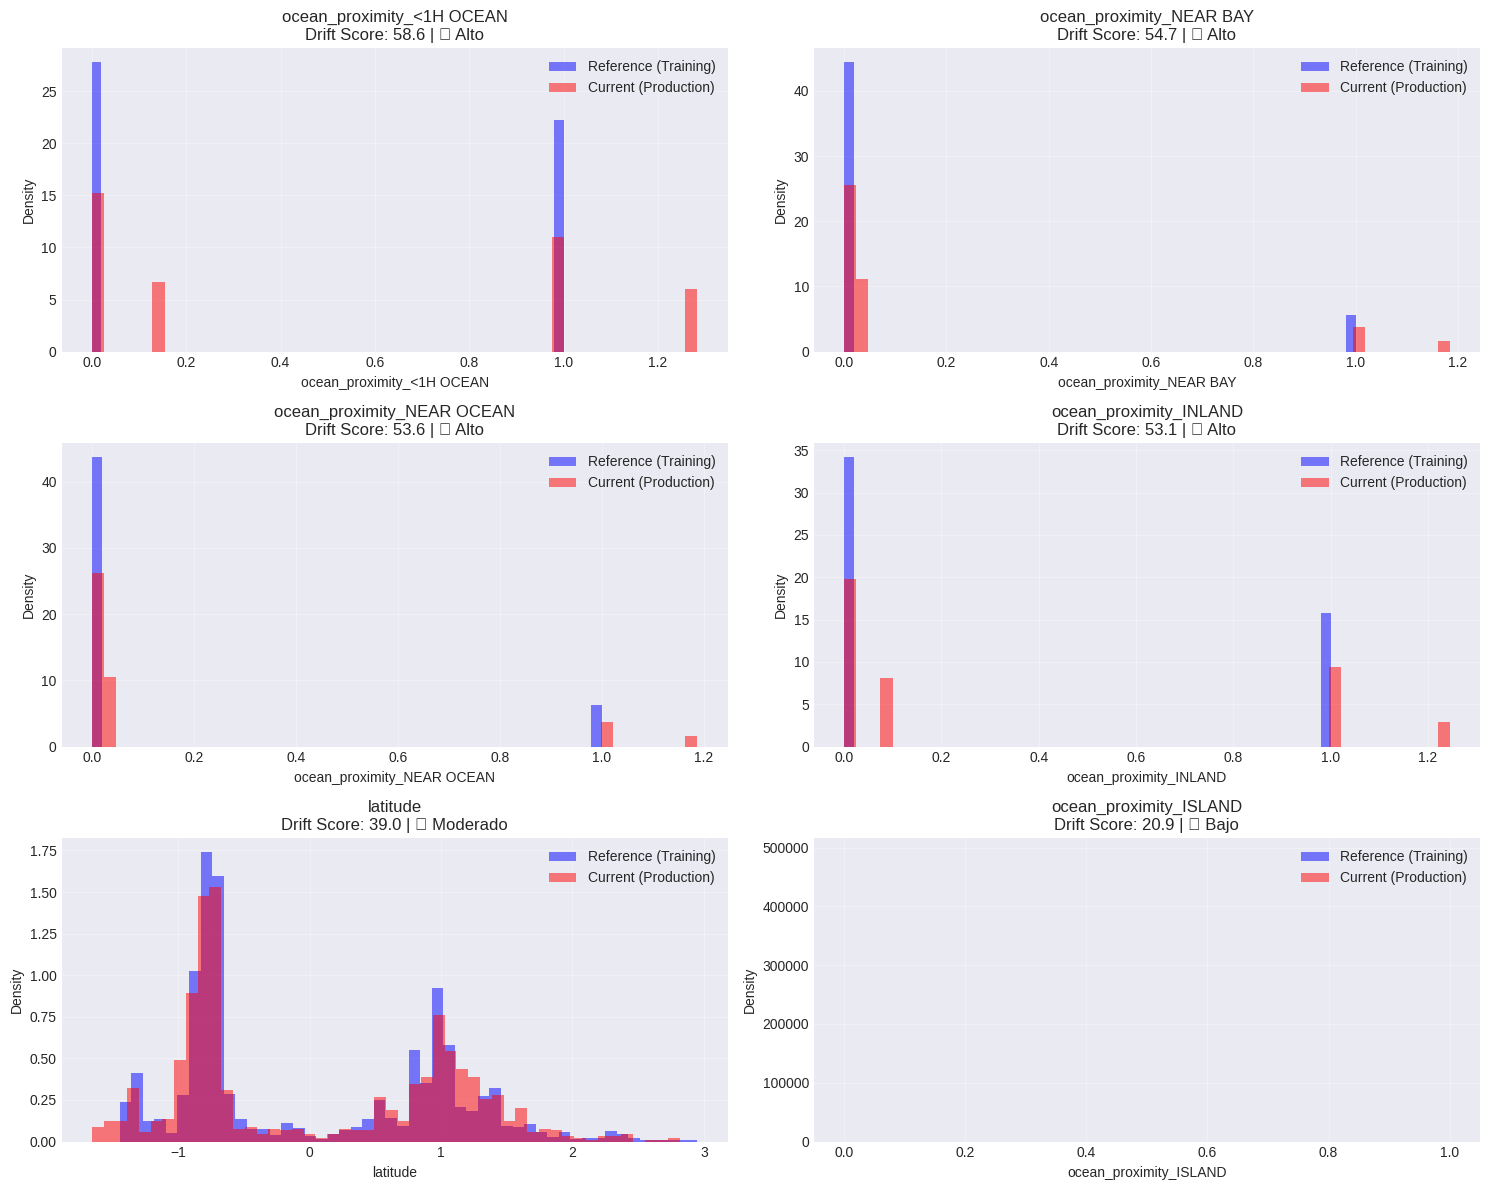

✓ Gráfico de distribuciones guardado: distribution_comparison_20251110_061351.png


In [29]:
# Visualizar distribuciones de los features con mayor drift
top_drift_features = drift_summary.head(6)['feature'].tolist()

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_drift_features):
    ax = axes[idx]
    
    # Histogramas superpuestos
    ax.hist(reference_data[feature], bins=50, alpha=0.5, label='Reference (Training)', 
            color='blue', density=True)
    ax.hist(current_data[feature], bins=50, alpha=0.5, label='Current (Production)', 
            color='red', density=True)
    
    # Obtener métricas de drift para el feature
    feature_drift = drift_summary[drift_summary['feature'] == feature].iloc[0]
    
    ax.set_title(f"{feature}\nDrift Score: {feature_drift['drift_score']:.1f} | {feature_drift['risk_level']}")
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MONITORING_DIR, f'distribution_comparison_{timestamp}.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico de distribuciones guardado: distribution_comparison_{timestamp}.png")

## 8. Reporte con Evidently AI

In [30]:
# Generar reporte completo con Evidently (si está disponible)
if EVIDENTLY_AVAILABLE:
    try:
        # Preparar datos para Evidently (sin target para evitar warnings)
        reference_for_evidently = reference_data.drop(columns=['target'])
        current_for_evidently = current_data.drop(columns=['target'])
        
        # Crear reporte
        data_drift_report = Report(metrics=[
            DataDriftPreset(),
            DataQualityPreset()
        ])
        
        # Ejecutar reporte
        data_drift_report.run(
            reference_data=reference_for_evidently,
            current_data=current_for_evidently
        )
        
        # Guardar reporte HTML
        evidently_report_path = os.path.join(MONITORING_DIR, f'evidently_report_{timestamp}.html')
        data_drift_report.save_html(evidently_report_path)
        
        print("=" * 80)
        print("REPORTE EVIDENTLY AI GENERADO")
        print("=" * 80)
        print(f"Archivo: {evidently_report_path}")
        print(f"\nEl reporte incluye:")
        print("  • Data Drift Preset: Análisis completo de drift por feature")
        print("  • Data Quality Preset: Métricas de calidad de datos")
        print("  • Visualizaciones interactivas")
        print("  • Tests estadísticos automáticos")
        print("=" * 80)
    except Exception as e:
        print("=" * 80)
        print("⚠️  ERROR AL GENERAR REPORTE EVIDENTLY")
        print("=" * 80)
        print(f"Error: {str(e)}")
        print("\nSe continuará con tests estadísticos personalizados.")
        print("=" * 80)
else:
    print("=" * 80)
    print("REPORTE EVIDENTLY NO DISPONIBLE")
    print("=" * 80)
    print("Se utilizaron tests estadísticos personalizados:")
    print("  • Kolmogorov-Smirnov Test")
    print("  • Population Stability Index (PSI)")
    print("  • Jensen-Shannon Divergence")
    print("  • Chi-cuadrado Test (categóricos)")
    print("=" * 80)

REPORTE EVIDENTLY NO DISPONIBLE
Se utilizaron tests estadísticos personalizados:
  • Kolmogorov-Smirnov Test
  • Population Stability Index (PSI)
  • Jensen-Shannon Divergence
  • Chi-cuadrado Test (categóricos)


## 9. Sistema de Alertas y Recomendaciones

In [31]:
# Definir umbrales de alerta
THRESHOLDS = {
    'critical': 75,  # Drift score crítico
    'high': 50,      # Drift score alto
    'moderate': 25   # Drift score moderado
}

# Generar alertas
def generate_alerts(drift_summary, thresholds):
    """
    Genera alertas basadas en umbrales de drift.
    """
    alerts = []
    
    # Contar features por nivel de riesgo
    critical_features = drift_summary[drift_summary['drift_score'] >= thresholds['critical']]
    high_features = drift_summary[
        (drift_summary['drift_score'] >= thresholds['high']) & 
        (drift_summary['drift_score'] < thresholds['critical'])
    ]
    moderate_features = drift_summary[
        (drift_summary['drift_score'] >= thresholds['moderate']) & 
        (drift_summary['drift_score'] < thresholds['high'])
    ]
    
    # Alerta crítica
    if len(critical_features) > 0:
        alerts.append({
            'level': '🔴 CRÍTICO',
            'message': f'{len(critical_features)} features con drift crítico detectado',
            'features': critical_features['feature'].tolist()[:5],  # Top 5
            'recommendation': 'REENTRENAMIENTO INMEDIATO DEL MODELO REQUERIDO'
        })
    
    # Alerta alta
    if len(high_features) > 0:
        alerts.append({
            'level': '🟠 ALTO',
            'message': f'{len(high_features)} features con drift alto detectado',
            'features': high_features['feature'].tolist()[:5],
            'recommendation': 'Planificar reentrenamiento del modelo en los próximos 7 días'
        })
    
    # Alerta moderada
    if len(moderate_features) > 0:
        alerts.append({
            'level': '🟡 MODERADO',
            'message': f'{len(moderate_features)} features con drift moderado detectado',
            'features': moderate_features['feature'].tolist()[:5],
            'recommendation': 'Monitorear continuamente. Considerar reentrenamiento si persiste'
        })
    
    # Sin alertas
    if len(alerts) == 0:
        alerts.append({
            'level': '🟢 NORMAL',
            'message': 'No se detectó drift significativo',
            'features': [],
            'recommendation': 'Modelo operando normalmente. Continuar monitoreo'
        })
    
    return alerts

# Generar alertas
alerts = generate_alerts(drift_summary, THRESHOLDS)

# Mostrar alertas
print("\n" + "=" * 80)
print("🚨 SISTEMA DE ALERTAS - DATA DRIFT MONITORING")
print("=" * 80)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total features monitoreados: {len(drift_summary)}")
print("\n" + "-" * 80)

for alert in alerts:
    print(f"\n{alert['level']}: {alert['message']}")
    if alert['features']:
        print(f"Features afectados: {', '.join(alert['features'])}")
    print(f"Recomendación: {alert['recommendation']}")
    print("-" * 80)

print("\n" + "=" * 80)

# Guardar alertas en JSON
alerts_file = os.path.join(MONITORING_DIR, f'alerts_{timestamp}.json')
import json
with open(alerts_file, 'w') as f:
    json.dump({
        'timestamp': timestamp,
        'total_features': len(drift_summary),
        'alerts': alerts
    }, f, indent=2)

print(f"\n✓ Alertas guardadas: {alerts_file}")


🚨 SISTEMA DE ALERTAS - DATA DRIFT MONITORING
Timestamp: 2025-11-10 06:14:34
Total features monitoreados: 16

--------------------------------------------------------------------------------

🟠 ALTO: 4 features con drift alto detectado
Features afectados: ocean_proximity_<1H OCEAN, ocean_proximity_NEAR BAY, ocean_proximity_NEAR OCEAN, ocean_proximity_INLAND
Recomendación: Planificar reentrenamiento del modelo en los próximos 7 días
--------------------------------------------------------------------------------

🟡 MODERADO: 1 features con drift moderado detectado
Features afectados: latitude
Recomendación: Monitorear continuamente. Considerar reentrenamiento si persiste
--------------------------------------------------------------------------------


✓ Alertas guardadas: ../monitoring_reports/alerts_20251110_061351.json


## 10. Conclusiones del Monitoreo

In [34]:
# Resumen final del monitoreo
print("=" * 80)
print("📊 CONCLUSIONES DEL MONITOREO DE DATA DRIFT")
print("=" * 80)

# Estadísticas generales
total_features = len(drift_summary)
features_with_drift = len(drift_summary[drift_summary['drift_score'] >= THRESHOLDS['moderate']])
drift_percentage = (features_with_drift / total_features) * 100

print(f"\n1. ESTADÍSTICAS GENERALES:")
print(f"   • Total de features monitoreados: {total_features}")
print(f"   • Features con drift detectado: {features_with_drift} ({drift_percentage:.1f}%)")
print(f"   • Features sin drift: {total_features - features_with_drift}")

print(f"\n2. DISTRIBUCIÓN POR NIVEL DE RIESGO:")
risk_counts = drift_summary['risk_level'].value_counts()
for level, count in risk_counts.items():
    percentage = (count / total_features) * 100
    print(f"   • {level}: {count} features ({percentage:.1f}%)")

print(f"\n3. MÉTRICAS PROMEDIO:")
print(f"   • PSI promedio: {drift_summary['psi'].mean():.4f}")
print(f"   • JS Divergence promedio: {drift_summary['js_divergence'].mean():.4f}")
print(f"   • Drift Score promedio: {drift_summary['drift_score'].mean():.2f}")

print(f"\n4. TOP 5 FEATURES CON MAYOR DRIFT:")
for idx, row in drift_summary.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']}: Score={row['drift_score']:.1f} ({row['risk_level']})")

print(f"\n5. RECOMENDACIÓN FINAL:")
if drift_summary['drift_score'].max() >= THRESHOLDS['critical']:
    print("   🔴 ACCIÓN REQUERIDA: Reentrenar el modelo INMEDIATAMENTE")
    print("      Drift crítico detectado que compromete la precisión del modelo.")
elif drift_summary['drift_score'].max() >= THRESHOLDS['high']:
    print("   🟠 ALERTA: Planificar reentrenamiento en corto plazo (7 días)")
    print("      Drift significativo detectado. Monitorear continuamente.")
elif drift_summary['drift_score'].max() >= THRESHOLDS['moderate']:
    print("   🟡 ADVERTENCIA: Monitorear de cerca")
    print("      Drift moderado. Evaluar reentrenamiento si persiste.")
else:
    print("   🟢 NORMAL: Modelo operando correctamente")
    print("      No se detectó drift significativo. Continuar monitoreo regular.")

print(f"\n6. ARCHIVOS GENERADOS:")
print(f"   • Resumen CSV: drift_summary_{timestamp}.csv")
print(f"   • Dashboard HTML: drift_dashboard_{timestamp}.html")
print(f"   • Alertas JSON: alerts_{timestamp}.json")
print(f"   • Distribuciones PNG: distribution_comparison_{timestamp}.png")

print("\n" + "=" * 80)
print("✓ Monitoreo completado exitosamente")
print("=" * 80)

📊 CONCLUSIONES DEL MONITOREO DE DATA DRIFT

1. ESTADÍSTICAS GENERALES:
   • Total de features monitoreados: 16
   • Features con drift detectado: 5 (31.2%)
   • Features sin drift: 11

2. DISTRIBUCIÓN POR NIVEL DE RIESGO:
   • 🟢 Bajo: 11 features (68.8%)
   • 🟠 Alto: 4 features (25.0%)
   • 🟡 Moderado: 1 features (6.2%)

3. MÉTRICAS PROMEDIO:
   • PSI promedio: 0.0108
   • JS Divergence promedio: 0.1399
   • Drift Score promedio: 22.56

4. TOP 5 FEATURES CON MAYOR DRIFT:
   5. ocean_proximity_<1H OCEAN: Score=58.6 (🟠 Alto)
   2. ocean_proximity_NEAR BAY: Score=54.7 (🟠 Alto)
   3. ocean_proximity_NEAR OCEAN: Score=53.6 (🟠 Alto)
   4. ocean_proximity_INLAND: Score=53.1 (🟠 Alto)
   6. latitude: Score=39.0 (🟡 Moderado)

5. RECOMENDACIÓN FINAL:
   🟠 ALERTA: Planificar reentrenamiento en corto plazo (7 días)
      Drift significativo detectado. Monitorear continuamente.

6. ARCHIVOS GENERADOS:
   • Resumen CSV: drift_summary_20251110_061351.csv
   • Dashboard HTML: drift_dashboard_20251110_0